# Objective
- Demonstrate the effect of downsampling and matched cohorts have on outcomes

In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib

import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt
import subprocess

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [3]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/eval_5_cc/simsurv_func.py'>

# Data Generator

VARS:
- 0 = covid binary 90:10 (0:1)
- 1 = age numeric (0-100) uniform
- 2 = numeric (0-3) uniform
- 3 = numeric (0-1) uniform
- 4 = binary (10:90) (0:1)

- Additonal 5 non contributory variables
- Weak direct effect of COVID but still has noticable mean difference by 360 days
- Weak interaction effect with age

In [79]:
OUTPUTS = "outputs"
ALPHA = 3
ALPHA_F = "2 - .5*x_mat[:,0]"
# ALPHA_F = None
VAR_CLASS = [2,100,3,1,2]
VAR_PROB = [0.1, 0.5, 0.5, 0.2, 0.9]
# friedman 5 dimension function
# LAMBDA = "0.001 * np.exp(3+0.5*np.sin(np.pi*x_mat[:,0]*x_mat[:,1]) + np.power(x_mat[:,2],2) + 0.5*x_mat[:,3] + 0.25*x_mat[:,4])" 
# LAMBDA = "np.exp(-8.4 + 0.2*x_mat[:,0] + 0.2*np.log(x_mat[:,1]) + x_mat[:,0]*0.01*np.log(x_mat[:,1])  + 0.001*np.power(x_mat[:,2],2) + 0.09*(x_mat[:,3]*x_mat[:,4]))" 
LAMBDA = "np.exp(-9.4 + 0.2*x_mat[:,0] + 0.2*np.log(x_mat[:,1]) + x_mat[:,0]*0.05*np.log(x_mat[:,1])  + 0.01*np.power(x_mat[:,2],2) + 0.5*(x_mat[:,3]*x_mat[:,4]))" 

N = 10000
# T = 30
X_VARS = 10
CENS_SCALE = 5# 40
CENS_IND = False
T_CHNG = None

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                VAR_CLASS= VAR_CLASS,
                VAR_PROB = VAR_PROB,
                a = ALPHA,
                alpha_f=ALPHA_F,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False,
                T_CHNG=T_CHNG)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)

# plots moved to kpm by group
title = "actual_survival"
# ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")


cens_calc: 0.0     
t_mean: 4008.2736     
t_max: 31080.0


In [80]:
# get check of survival probability in coivd vs non covid group
cov_msk = np.where(x_mat[:,0] == 1)
print("MEAN SV Prob at 360 days")
print(sv_mat[cov_msk[0],:].mean(0)[360])
print(sv_mat[~cov_msk[0],:].mean(0)[360])


MEAN SV Prob at 360 days
0.9584164208474117
0.9889696591984722


### KPM of the FULL TRAIN

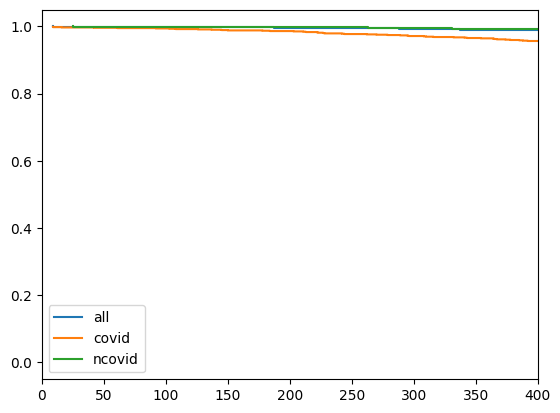

In [81]:
cov_mask = (x_mat[:,0]==1)
y_sk = ssf.get_y_sklearn(status, t_event)

kpm_all = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][cov_mask], y_sk["Survival_in_days"][cov_mask])
kpm_ncov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~cov_mask], y_sk["Survival_in_days"][~cov_mask])
plt.step(kpm_all[0], kpm_all[1], label="all")
plt.step(kpm_cov[0], kpm_cov[1], label="covid")
plt.step(kpm_ncov[0], kpm_ncov[1], label="ncovid")
plt.xlim(0,400)
plt.legend()

In [82]:
TT_ADJ = 430
TT_SCALE = 90
def get_sv_adj(sv_mat, TT_ADJ, TT_SCALE, MSK=None):
    t_msk = np.array(np.arange(0,np.ceil(TT_ADJ/TT_SCALE) + 1) * TT_SCALE, dtype="int")
    sv_true_t = sv_mat[:,t_msk]
    if MSK:
        sv_true_t = sv_true_t[MSK,:]
    t_len = len(t_msk)
    return sv_true_t, t_len

sv_true_full, t_len_full = get_sv_adj(sv_mat, TT_ADJ, TT_SCALE)

In [83]:
sv_mat = []

# Transform scale day

In [84]:
TT_ADJ = 430
TT_SCALE = 90
def get_t_adj(t_event, TT_ADJ, TT_SCALE):
    tt_ind = t_event.copy()
    y_stat = t_event.copy()
    tt_ind[tt_ind>= TT_ADJ] = TT_ADJ
    tt_sc = np.ceil(tt_ind/TT_SCALE)

    y_stat[tt_ind >= TT_ADJ] = 0
    y_stat[tt_ind < TT_ADJ] = 1
    return y_stat, tt_sc


y_stat, tt_sc = get_t_adj(t_event, TT_ADJ=TT_ADJ, TT_SCALE=TT_SCALE)

y_sk = ssf.get_y_sklearn(y_stat, tt_sc)
x_sk = train.iloc[:,2:]

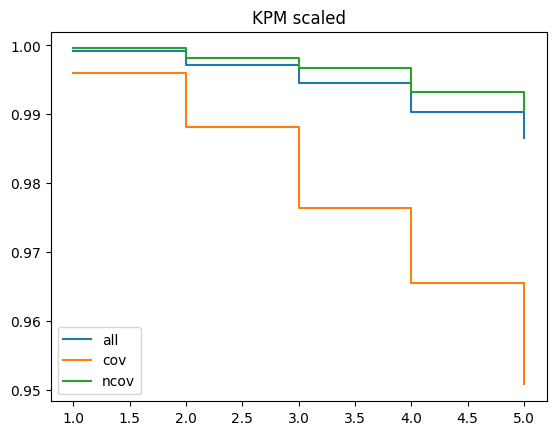

In [85]:
# Full Cohort
cov_mask = (x_mat[:,0]==1)
kpm_adj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][cov_mask], y_sk["Survival_in_days"][cov_mask])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~cov_mask], y_sk["Survival_in_days"][~cov_mask])

plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post")
plt.title("KPM scaled")
plt.legend()

In [86]:
print(f"covid events {y_stat[cov_mask].sum()}")
print(f"covid cases {y_stat[cov_mask].shape[0]}")
print(f"ncov events {y_stat[~cov_mask].sum()}")
print(f"ncov cases {y_stat[~cov_mask].shape[0]}")

covid events 50.0
covid cases 1016
ncov events 84.0
ncov cases 8984


- This is about the same proportions that we see in the Premier data.
only about 10% of cases are covid and of those we only see ~10% have events.
- In total only ~5% of the obs have events

# Get Test Dataset

In [170]:
# Test
def get_test(N = 100, VAR_CLASS=None, VAR_PROB=None):
    sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                    N=N, 
                    x_vars=X_VARS,
                    VAR_CLASS= VAR_CLASS,
                    VAR_PROB = VAR_PROB,
                    a = ALPHA,
                    alpha_f=ALPHA_F,
                    lambda_f = LAMBDA,
                    cens_scale=CENS_SCALE,
                    cens_ind = CENS_IND,
                    err_ind = False,
                    T_CHNG=T_CHNG)


    # Get information of X vars
    x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
    # calculate censored components
    event_calc, cens_calc = ssf.get_status_perc(status) 
    # Get the t mean and max
    t_mean, t_max = ssf.get_event_time_metric(t_event)
    # Get the training matrix
    train = ssf.get_train_matrix(x_mat, t_event, status)
    return sv_mat, x_mat, train, t_event, status, T

T_VAR_CLASS = [2,100,3,1,2]
T_VAR_PROB = [0.5, 0.5, 0.5, 0.2, 0.9]
te_sv_mat, te_x_mat, te_train, te_t_event, te_status, te_T = get_test(10000, T_VAR_CLASS, T_VAR_PROB)

te_cov_mask = (te_x_mat[:,0]==1)
# te_event_mask = (tb)

In [171]:
# Transform to scale
TT_ADJ = 430
TT_SCALE = 90
def get_t_adj(t_event, TT_ADJ, TT_SCALE):
    tt_ind = t_event.copy()
    y_stat = t_event.copy()
    tt_ind[tt_ind>= TT_ADJ] = TT_ADJ
    tt_sc = np.ceil(tt_ind/TT_SCALE)

    y_stat[tt_ind >= TT_ADJ] = 0
    y_stat[tt_ind < TT_ADJ] = 1
    return y_stat, tt_sc

def get_sv_adj(sv_mat, TT_ADJ, TT_SCALE, MSK=None):
    t_msk = np.array(np.arange(0,np.ceil(TT_ADJ/TT_SCALE) + 1) * TT_SCALE, dtype="int")
    sv_true_t = sv_mat[:,t_msk]
    if MSK:
        sv_true_t = sv_true_t[MSK,:]
    t_len = len(t_msk)
    return sv_true_t, t_len

te_y_stat, te_tt_sc = get_t_adj(te_t_event, TT_ADJ=TT_ADJ, TT_SCALE=TT_SCALE)

te_sv_true_t, te_t_len = get_sv_adj(te_sv_mat, TT_ADJ, TT_SCALE)

print(f"covid events {te_y_stat[te_cov_mask].sum()}")
print(f"covid cases {te_y_stat[te_cov_mask].shape[0]}")
print(f"ncov events {te_y_stat[~te_cov_mask].sum()}")
print(f"ncov cases {te_y_stat[~te_cov_mask].shape[0]}")

covid events 254.0
covid cases 5009
ncov events 42.0
ncov cases 4991


In [172]:
# Finish test data prep
te_y_msk = te_y_stat == 1
y1_N = te_y_msk.sum()
te_sv_y1 = te_sv_true_t[te_y_msk,:]
te_sv_y2 = te_sv_true_t[~te_y_msk,:][0:y1_N]

# covid mask in test
te_cov_msk = (te_x_mat[:,0]==1)
c1_N = te_cov_msk.sum()
te_sv_c1 = te_sv_true_t[te_cov_msk,:][0:c1_N]
te_sv_c2 = te_sv_true_t[~te_cov_msk,:][0:c1_N]

# Test dataset with all cases and 100 controls
te_y_sk = ssf.get_y_sklearn(te_y_stat, te_tt_sc)
te_y_sk = np.hstack([
    te_y_sk[te_y_msk],
    te_y_sk[~te_y_msk][0:y1_N]
])
te_x_sk = te_train.iloc[:,2:]
te_x_sk = pd.concat([
    te_x_sk.iloc[te_y_msk,:],
    te_x_sk.iloc[~te_y_msk,:][0:y1_N]
])
te_sv_f = np.vstack([te_sv_y1, te_sv_y2]) 

te_b_tr_t, te_b_tr_delta, te_b_tr_x = ssf.surv_pre_train2(te_x_sk, te_y_sk)
te_b_te_x = ssf.get_bart_test(te_x_sk, np.unique(te_b_tr_t)) 
te_off = sp.norm.ppf(np.mean(te_b_tr_delta))

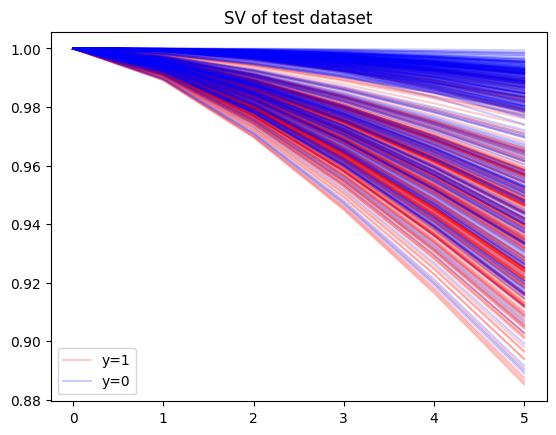

In [173]:
te_times = np.arange(0,te_t_len)

cnt = 1
for i in te_sv_y1:
    if cnt==1:
        plt.plot(te_times, i, color="red", alpha=0.2, label="y=1")
        cnt+=1
    plt.plot(te_times, i, color="red", alpha=0.2)
    
for i in te_sv_y2:
    if cnt == 2:
        cnt+=1
        plt.plot(te_times, i, color="blue", alpha=0.2, label="y=0")
    plt.plot(te_times, i, color="blue", alpha=0.2)
plt.title("SV of test dataset")
plt.legend()

Seperated by y=1,0

We can see that the y=1 group is not distinctly different than the y=0. 

However we can see the y=1 group generally decreased survival probabilities in comparsion to the y=0 group. 

There is a secondary divide noticable that probably aligns with the covid-noncovid seperation.

# Case-Cohort

In [147]:
case_mask = (y_sk["Status"] == True)
case_y = y_sk[case_mask]
case_x = x_sk[case_mask]

PRCNT = .1
NSMP = int(N*PRCNT)
sample_mask = np.random.choice(np.arange(0,x_sk.shape[0]), NSMP, replace=False)

sub_x = x_sk.iloc[sample_mask,:]
sub_y = y_sk[sample_mask]

# join cohort
coh_x = pd.concat([case_x, sub_x])
coh_y = np.concatenate([case_y, sub_y])


In [148]:
print(case_x.shape)
print(sub_x.shape)
print(f"FULL {coh_x.shape}")

(134, 10)
(1000, 10)
FULL (1134, 10)


In [232]:
# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(coh_x, coh_y)
b_te_x = ssf.get_bart_test(coh_x, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

In [233]:
# get weights
cntrl_msk = np.where(coh_y["Status"]==False)
weight = np.ones(coh_y.shape)
weight[cntrl_msk] = (1/PRCNT)
intl = [x for x in coh_y["Survival_in_days"].tolist()]
www = np.repeat(weight, intl)

Becasue we increased the ratio of outcome in the case-cohort dataset, we can see that the SV is strongly biased

# BART

- Train bart model
- Split rules are defined by var type
    - the first var is now time and is always continuous
    - the extra 5 vars are continuous

## BART with Weighted LogProb and Posterior Predictive 

In [234]:
# BART
M = 15 # number of trees
DRAWS = 1000
TUNE = 500
CORES = 1
SPLIT_RULES = [
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule,
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule()
]

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)


with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    weight = pm.MutableData("w", www)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
    z = pm.Deterministic("z", (f + off))
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    # y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])    # For direct sample
    # y_pred = pm.Potential("y_pred", weight * pm.logp(pm.Bernoulli.dist(p=mu), b_tr_delta)) # for weighted no posterior predictive
    y_pred = pm.CustomDist("y_pred", mu, weight, dist=dist_bern, logp=logp_bern, observed=b_tr_delta, shape = x_data.shape[0])
    # bdata = pm.sample(100, cores=2)
    bdata = pm.sample(draws=DRAWS, tune=TUNE, cores=4,compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 35 seconds.


In [235]:
# get the posterior predictions
with bart:
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names=["mu"])

Sampling: [f]


In [193]:
def get_sv_fx(pp, r0, r1):
    p0 = pp.posterior_predictive["mu"].values.shape[0]
    p1 = pp.posterior_predictive["mu"].values.shape[1]
    p2 = pp.posterior_predictive["mu"].values.shape[2]
    pp_post = pp.posterior_predictive["mu"].values.reshape(p0*p1, p2).mean(axis=0).reshape(r0, r1)
    sv = (1-pp_post).cumprod(axis=1)
    return sv

def get_sv_wrap(coh_y, b_tr_t, pp):
    smp_t_shp= np.unique(coh_y["Survival_in_days"]).shape[0]
    smp_shp = coh_y.shape[0]

    t_min = np.unique(b_tr_t).min()
    t_fill = np.arange(t_min)
    val_fill = np.ones(t_fill.shape)
    npat = coh_y.shape[0]
    val_fill = np.repeat(val_fill, npat).reshape(npat,val_fill.shape[0])

    bart_sv_fx = get_sv_fx(pp, smp_shp,smp_t_shp)
    bart_sv_val = np.hstack([val_fill, bart_sv_fx])

    bart_sv_t = np.unique(b_tr_t)
    bart_sv_t = np.hstack([t_fill, bart_sv_t])
    return bart_sv_val, bart_sv_t



In [236]:
bart_sv_val, bart_sv_t = get_sv_wrap(coh_y, b_tr_t, pp)

## Posterior Predictive Plot
- posterior predictive check on training samples

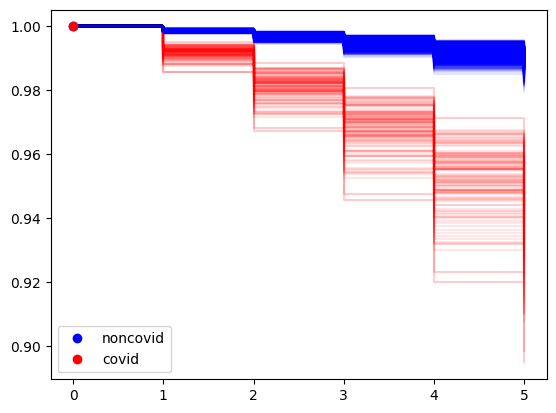

In [237]:
# Plot the posterior predictions
coh_cov_msk = np.array(coh_x.iloc[:,0]==1)

for r in np.arange(0, bart_sv_val.shape[0]):
    if coh_cov_msk[r] == 1:
        col = "red"
        lab="covid"
    else:
        col = "blue"
        lab="noncovid"        
    plt.step(bart_sv_t, bart_sv_val[r,:], alpha=0.1, color=col, where="post")
plt.plot(0,1, "bo", label="noncovid")
plt.plot(0,1, "ro", label="covid")

plt.legend()

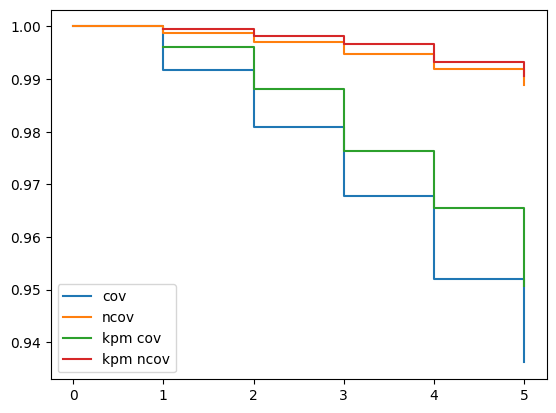

In [238]:
full_cov_mask = (x_mat[:,0]==1)
# kpm_adj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][full_cov_mask], y_sk["Survival_in_days"][full_cov_mask])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~full_cov_mask], y_sk["Survival_in_days"][~full_cov_mask])

# plot BART
plt.step(bart_sv_t, bart_sv_val[coh_cov_msk].mean(0), label="cov", where="post")
plt.step(bart_sv_t, bart_sv_val[~coh_cov_msk].mean(0), label="ncov", where="post")

# plot KPM FULL
plt.step(kpm_cadj[0], kpm_cadj[1], label="kpm cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="kpm ncov", where="post")
plt.legend()


The posterior predictions do a good job of estimating the SV probability in comparison to the Full KPM

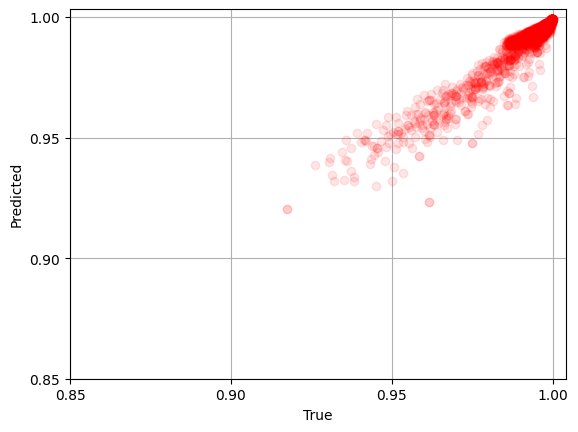

In [239]:
# sample_mask.shape

# sv_true_t, t_len = get_sv_adj(sv_true_full, TT_ADJ, TT_SCALE)
# sv_true_t1 = sv_true_t[case_mask,:]
# sv_true_t2 = sv_true_t[sample_mask,:]
# sv_true_t = np.vstack([sv_true_t1, sv_true_t2])
sv_true_t1 = sv_true_full[case_mask,:]
sv_true_t2 = sv_true_full[sample_mask,:]
sv_true_t = np.vstack([sv_true_t1, sv_true_t2])


assert sv_true_t.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(sv_true_t[i,1:-1],bart_sv_val[i,1:-1],"ro", alpha=0.1)
plt.ylabel("Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.85,1, 0.05))
plt.yticks(np.arange(0.85,1, 0.05))
plt.grid(visible="true")



The TRUE=PRED plot displays a good relationship between the TRUE and Pred values. There is some bias in the predictions, but the variance is not massive and the predictions appear fairly centered on the 1:1 line

In [240]:
shp1,shp2,shp3 = pp.posterior_predictive["mu"].values.shape
shp4 = coh_x.shape[0]
shp5 = np.unique(b_tr_t).shape[0]

bart_hz1 = pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
bart_chz1 = np.cumsum(bart_hz1, axis=1)

for i in np.arange(bart_hz1.shape[1]):
    ci = concordance_index_censored(coh_y["Status"], coh_y["Survival_in_days"], bart_hz1[:,i])
    print(f"bart cindex {i}: {ci}")


bart cindex 0: (0.7422272197127374, 115185, 40003, 1, 40385)
bart cindex 1: (0.7424366417722905, 115217, 39970, 2, 40385)
bart cindex 2: (0.7421756696673089, 115177, 40011, 1, 40385)
bart cindex 3: (0.7413927533523639, 115056, 40133, 0, 40385)
bart cindex 4: (0.7415248503437744, 115076, 40112, 1, 40385)


## Test Case:Cohort 

In [241]:
with bart:
    pm.set_data({"x":pd.DataFrame(te_b_te_x)}, coords= {"obs":np.arange(0,te_b_te_x.shape[0],1)})
    te_pp = pm.sample_posterior_predictive(bdata, var_names=["mu"])

Sampling: [f]


In [242]:
te_bart_sv_val, te_bart_sv_t = get_sv_wrap(te_y_sk, te_b_tr_t, te_pp)

In [243]:
te_bart_sv_val.shape
te_sv_f.shape

(592, 6)

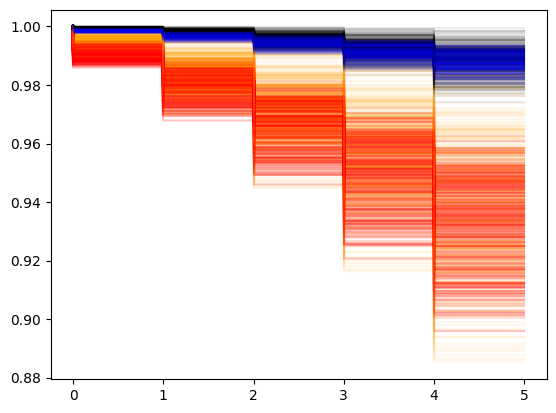

In [244]:
te_cov_msk = np.array(te_x_sk.iloc[:,0]==1)
for i in np.arange(0, te_bart_sv_val.shape[0]):
    if te_cov_msk[i]:
        col="red"
        col2 = "orange"
    else:
        col = "blue"
        col2 = "black"
    plt.step(te_bart_sv_t, te_bart_sv_val[i,:], color=col, alpha=0.12)
    plt.step(te_bart_sv_t, te_sv_f[i,:], color=col2, alpha=0.08)

In [245]:
p_c95 = np.quantile(te_bart_sv_val[te_cov_msk,:], [0.0275,0.975], axis=0)
p_nc95 = np.quantile(te_bart_sv_val[~te_cov_msk,:], [0.0275,0.975], axis=0)
t_c95 = np.quantile(te_sv_f[te_cov_msk,:], [0.0275,0.975], axis=0)
t_nc95 = np.quantile(te_sv_f[~te_cov_msk,:], [0.0275,0.975], axis=0)

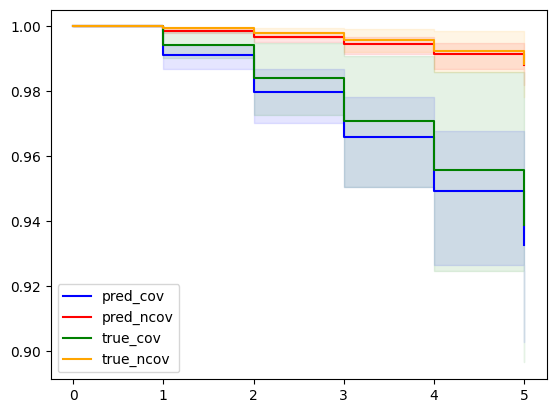

In [246]:
te_cov_msk = np.array(te_x_sk.iloc[:,0]==1)
plt.step(te_bart_sv_t, te_bart_sv_val[te_cov_msk,:].mean(0), label = "pred_cov", where="post", color="blue")
plt.fill_between(te_bart_sv_t, y1=p_c95[0,:], y2 = p_c95[1,:], step="post", alpha=0.1, color="blue")

plt.step(te_bart_sv_t, te_bart_sv_val[~te_cov_msk,:].mean(0), label = "pred_ncov", color="red", where="post")
plt.fill_between(te_bart_sv_t, y1=p_nc95[0,:], y2 = p_nc95[1,:], step="post", alpha=0.1, color="red")

plt.step(te_bart_sv_t, te_sv_f[te_cov_msk,:].mean(0), label = "true_cov", color="green", where="post")
plt.fill_between(te_bart_sv_t, y1=t_c95[0,:], y2 = t_c95[1,:], step="post", alpha=0.1, color="green")

plt.step(te_bart_sv_t, te_sv_f[~te_cov_msk,:].mean(0), label = "true_ncov", color="orange", where="post")
plt.fill_between(te_bart_sv_t, y1=t_nc95[0,:], y2 = t_nc95[1,:], step="post", alpha=0.1, color="orange")
plt.legend()

The predictive mean aligns well with the true values. 
The 95% interval is broader of the predictions than the true 95% interval. However this may be resolved with increased sampling. Current sample size is fairly small.

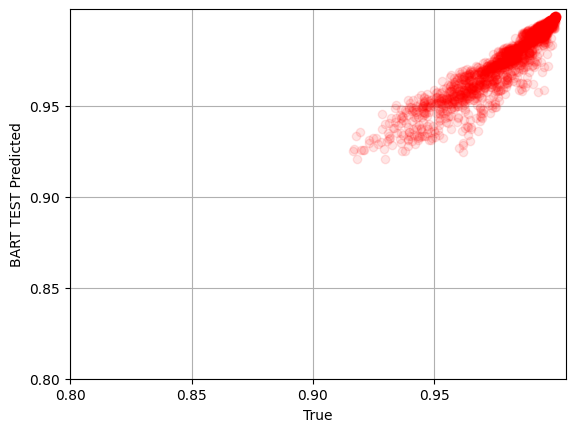

In [247]:
for i in np.arange(0,te_sv_f.shape[0]):
    plt.plot(te_sv_f[i,1:-1],te_bart_sv_val[i, 1:-1], "ro", alpha=0.1)
    # plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)

plt.ylabel("BART TEST Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.80,1, 0.05))
plt.yticks(np.arange(0.80,1, 0.05))
plt.grid(visible=True)

The True=Pred plot demonstrates a good relationshipt between the Predicted and Expeted valeus.

## COX Train Full and Predict on Test

In [248]:
cph = sks.linear_model.CoxPHSurvivalAnalysis().fit(x_sk, y_sk)
print(f"exp coef: {np.exp(cph.coef_)}")

# get test predictions
cph_sv = cph.predict_survival_function(te_x_sk)
cph_sv = np.array([fx(fx.x) for fx in cph_sv])

# we can reuse val_fill from above
cph_val_fill = np.repeat(0,cph_sv.shape[0]).reshape((cph_sv.shape[0],1))
cph_sv_val = np.hstack([cph_val_fill, cph_sv])

exp coef: [5.46498766 1.00994564 1.06467943 2.40955703 1.29125475 0.71101134
 1.17259829 1.21742381 1.05640109 0.78690642]


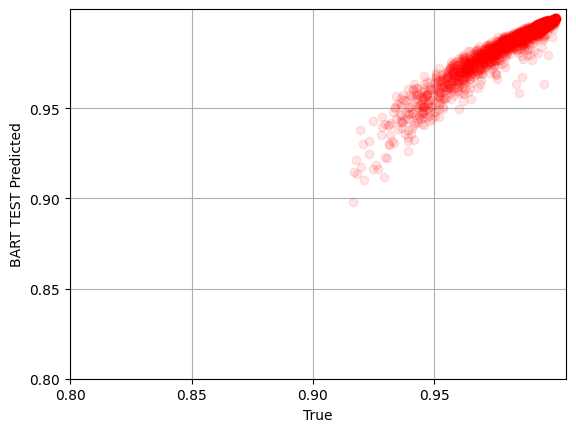

In [249]:
for i in np.arange(0,te_sv_f.shape[0]):
    plt.plot(te_sv_f[i,1:-1],cph_sv_val[i, 1:-1], "ro", alpha=0.1)
    # plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)

plt.ylabel("BART TEST Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.80,1, 0.05))
plt.yticks(np.arange(0.80,1, 0.05))
plt.grid(visible=True)

## C-index

In [250]:
shp1,shp2,shp3 = te_pp.posterior_predictive["mu"].values.shape
shp4 = te_x_sk.shape[0]
shp5 = np.unique(te_b_tr_t).shape[0]

bart_hz1 = te_pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
bart_chz1 = np.cumsum(bart_hz1, axis=1)
cph_chz = cph.predict_cumulative_hazard_function(te_x_sk)
cph_chz = np.array([fn(fn.x) for fn in cph_chz])

for i in np.arange(bart_hz1.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], bart_chz1[:,i])
    print(f"bart cindex {i}: {ci}")

for i in np.arange(cph_chz.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], cph_chz[:,i])
    print(f"cph cindex {i}: {ci}")


bart cindex 0: (0.6913479927441661, 84229, 37604, 0, 21904)
bart cindex 1: (0.6907323959846675, 84154, 37679, 0, 21904)
bart cindex 2: (0.6908062675958073, 84163, 37670, 0, 21904)
bart cindex 3: (0.6909827386668637, 84184, 37648, 1, 21904)
bart cindex 4: (0.6908555153365673, 84169, 37664, 0, 21904)
cph cindex 0: (0.6910442983428136, 84192, 37641, 0, 21904)
cph cindex 1: (0.6910442983428136, 84192, 37641, 0, 21904)
cph cindex 2: (0.6910442983428136, 84192, 37641, 0, 21904)
cph cindex 3: (0.6910442983428136, 84192, 37641, 0, 21904)
cph cindex 4: (0.6910442983428136, 84192, 37641, 0, 21904)


## Random Sample
- Test how a random sample to similar size performs

In [209]:
smpl_size = coh_y.shape[0]
full_size = x_sk.shape[0]
smp_msk = np.random.choice(np.arange(0, full_size), smpl_size, replace = False)
smp_x = x_sk.iloc[smp_msk,:]
smp_y = y_sk[smp_msk]

In [210]:
smp_cov_msk = smp_x.to_numpy()[:,0] == 1
smp_y_st = smp_y["Status"]
print(f"{smpl_size} obs")
print(f"covid events {smp_y_st[smp_cov_msk].sum()}")
print(f"covid cases {smp_y[smp_cov_msk].shape[0]}")
print(f"ncov events {smp_y_st[~smp_cov_msk].sum()}")
print(f"ncov cases {smp_y[~smp_cov_msk].shape[0]}")

1134 obs
covid events 4
covid cases 125
ncov events 10
ncov cases 1009


Initially we can see there are very few events

In [211]:
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(coh_x, coh_y)
b_te_x = ssf.get_bart_test(coh_x, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

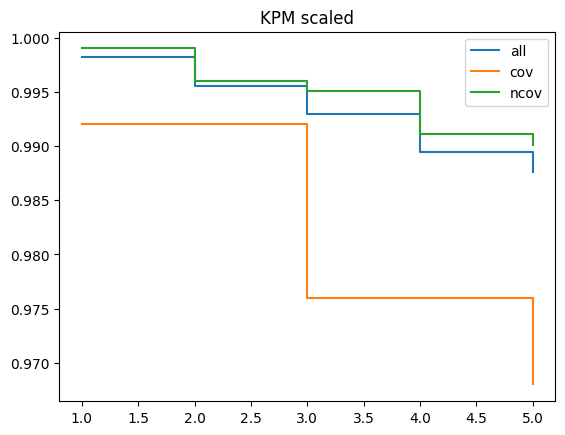

In [212]:
cov_mask = (x_mat[:,0]==1)
kpm_adj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"], smp_y["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"][smp_cov_msk], smp_y["Survival_in_days"][smp_cov_msk])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"][~smp_cov_msk], smp_y["Survival_in_days"][~smp_cov_msk])

plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post")
plt.title("KPM scaled")
plt.legend()

Based on the KPM we can see that a random sample down to the size of the case-cohort does a terrible job of return an approximated KPM to the full dataset

## Sample with a larger dataset
- 5x the case-cohort size

In [213]:
smpl_size = int(coh_y.shape[0] * 5)
full_size = x_sk.shape[0]
smp_msk = np.random.choice(np.arange(0, full_size), smpl_size, replace = False)
smp_x = x_sk.iloc[smp_msk,:]
smp_y = y_sk[smp_msk]

smp_cov_msk = smp_x.to_numpy()[:,0] == 1
smp_y_st = smp_y["Status"]
print(f"{smpl_size} obs")
print(f"covid events {smp_y_st[smp_cov_msk].sum()}")
print(f"covid cases {smp_y[smp_cov_msk].shape[0]}")
print(f"ncov events {smp_y_st[~smp_cov_msk].sum()}")
print(f"ncov cases {smp_y[~smp_cov_msk].shape[0]}")

5670 obs
covid events 30
covid cases 594
ncov events 56
ncov cases 5076


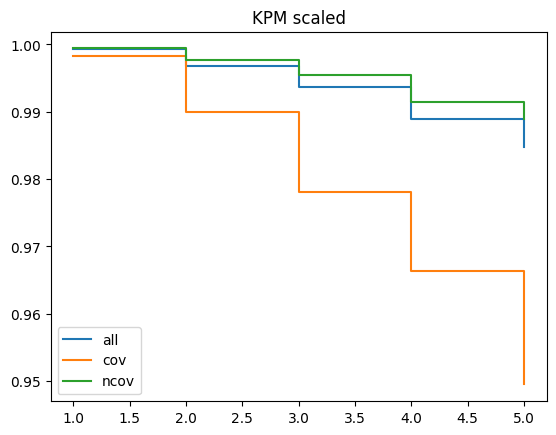

In [214]:

# KPM
cov_mask = (x_mat[:,0]==1)
kpm_adj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"], smp_y["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"][smp_cov_msk], smp_y["Survival_in_days"][smp_cov_msk])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(smp_y["Status"][~smp_cov_msk], smp_y["Survival_in_days"][~smp_cov_msk])

plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post")
plt.title("KPM scaled")
plt.legend()

With 5x the samples we start to approximate the full kpm

In [215]:
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(smp_x, smp_y)
b_te_x = ssf.get_bart_test(smp_x, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

M = 20 # number of trees
DRAWS = 100
TUNE = 100
CORES = 1
SPLIT_RULES = [
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule,
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule(),
    pmb.ContinuousSplitRule()
]

# custom logp
def logp_bern(value, mu, weight):
    return weight * pm.logp(pm.Bernoulli.dist(mu), value)
# extension of the bernoulli, the distribution is used as normal
def dist_bern(mu, weight, size):
    return pm.Bernoulli.dist(mu, size=size)


with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    weight = pm.MutableData("w", www)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
    z = pm.Deterministic("z", (f + off))
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])    # use classic bernoulli
    # y_pred = pm.Potential("y_pred", weight * pm.logp(pm.Bernoulli.dist(p=mu), b_tr_delta))
    # y_pred = pm.CustomDist("y_pred", mu, weight, dist=dist_bern, logp=logp_bern, observed=b_tr_delta, shape = x_data.shape[0])
    bdata = pm.sample(100, cores=4, compute_convergence_checks=False)

with bart:
    # x_data = pm.set_data({"x": b_te_x})
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names=["mu"])

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
PGBART: [f]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 159 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f]


In [216]:
smp_t_shp= np.unique(smp_y["Survival_in_days"]).shape[0]
smp_shp = smp_y.shape[0]

# transform to survival
# fill times
t_min = np.unique(b_tr_t).min()
t_fill = np.arange(t_min)
val_fill = np.ones(t_fill.shape)
npat = smp_y.shape[0]
val_fill = np.repeat(val_fill, npat).reshape(npat,val_fill.shape[0])

bart_sv_fx = get_sv_fx(pp, smp_shp, smp_t_shp)
bart_sv_val = np.hstack([val_fill, bart_sv_fx])

bart_sv_t = np.unique(b_tr_t)
bart_sv_t = np.hstack([t_fill, bart_sv_t])

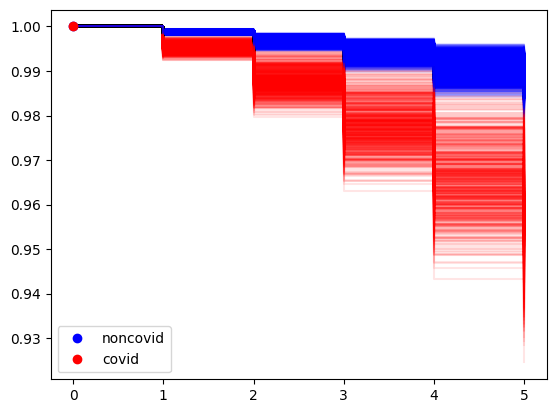

In [217]:
# Plot the posterior predictions
for r in np.arange(0, bart_sv_val.shape[0]):
    if smp_cov_msk[r] == 1:
        col = "red"
        lab="covid"
    else:
        col = "blue"
        lab="noncovid"
    plt.step(bart_sv_t, bart_sv_val[r,:], alpha=0.1, color=col, where="post")
plt.plot(0,1, "bo", label="noncovid")
plt.plot(0,1, "ro", label="covid")

# plt.step(bart_sv_t, , label="cov", where="post", color="black")
# plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post", color="black")
plt.legend()

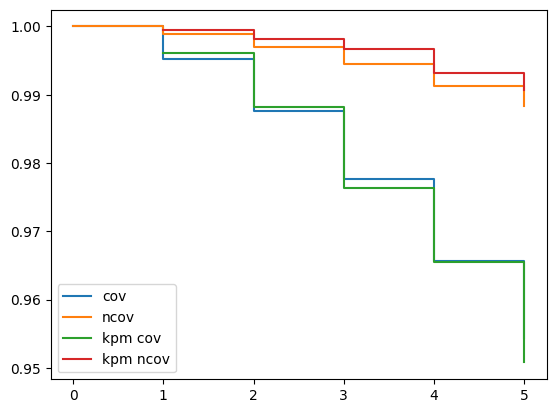

In [218]:
cov_mask = (x_mat[:,0]==1)
# kpm_adj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][cov_mask], y_sk["Survival_in_days"][cov_mask])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~cov_mask], y_sk["Survival_in_days"][~cov_mask])

plt.step(bart_sv_t, bart_sv_val[smp_cov_msk].mean(0), label="cov", where="post")
plt.step(bart_sv_t, bart_sv_val[~smp_cov_msk].mean(0), label="ncov", where="post")
# plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="kpm cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="kpm ncov", where="post")


plt.legend()

In comparison to the KPM estimates, we can see the sample w/ case_cohort*5 does worse than the the case cohort model relative to comparison to the full KPM

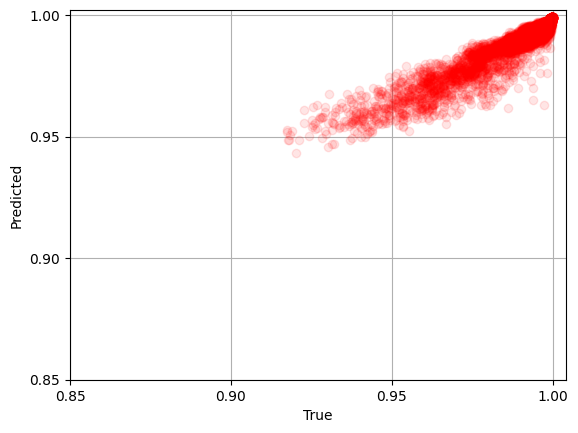

In [219]:
# get sv true
# t_msk = np.array(np.arange(0,np.ceil(TT_ADJ/TT_SCALE) + 1) * TT_SCALE, dtype="int")
# sv_true_t = sv_mat[:,t_msk]
# sv_true_t = sv_true_t[smp_msk,:]
# t_len = len(t_msk)
# sv_true_t = sv_true_full[:,t_msk]

sv_true_t = sv_true_full[smp_msk,:]
# t_len = len(t_msk)

assert sv_true_t.shape ==  bart_sv_val.shape

for i in np.arange(0,sv_true_t.shape[0]):
    plt.plot(sv_true_t[i,1:-1],bart_sv_val[i,1:-1],"ro", alpha=0.1)
plt.ylabel("Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.85,1, 0.05))
plt.yticks(np.arange(0.85,1, 0.05))
plt.grid(visible="true")

Sample cohort TRUE=PRED plot is fairly decent

### TEST Sample Cohort

In [220]:
with bart:
    pm.set_data({"x":pd.DataFrame(te_b_te_x)}, coords= {"obs":np.arange(0,te_b_te_x.shape[0],1)})
    te_pp = pm.sample_posterior_predictive(bdata, var_names=["mu"])

te_bart_sv_val, te_bart_sv_t = get_sv_wrap(te_y_sk, te_b_tr_t, te_pp)

Sampling: [f]


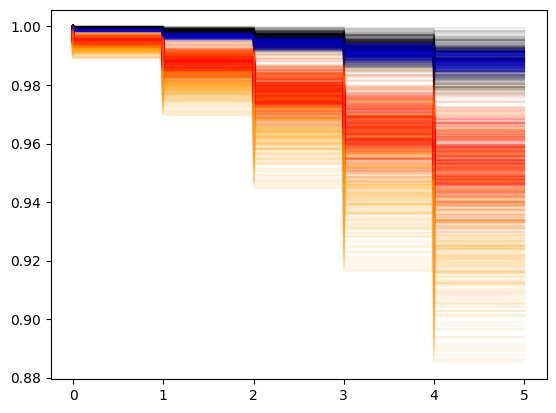

In [221]:
te_cov_msk = np.array(te_x_sk.iloc[:,0]==1)
for i in np.arange(0, te_bart_sv_val.shape[0]):
    if te_cov_msk[i]:
        col="red"
        col2 = "orange"
    else:
        col = "blue"
        col2 = "black"
    plt.step(te_bart_sv_t, te_bart_sv_val[i,:], color=col, alpha=0.08)
    plt.step(te_bart_sv_t, te_sv_f[i,:], color=col2, alpha=0.08)

In [222]:
p_c95 = np.quantile(te_bart_sv_val[te_cov_msk,:], [0.0275,0.975], axis=0)
p_nc95 = np.quantile(te_bart_sv_val[~te_cov_msk,:], [0.0275,0.975], axis=0)
t_c95 = np.quantile(te_sv_f[te_cov_msk,:], [0.0275,0.975], axis=0)
t_nc95 = np.quantile(te_sv_f[~te_cov_msk,:], [0.0275,0.975], axis=0)

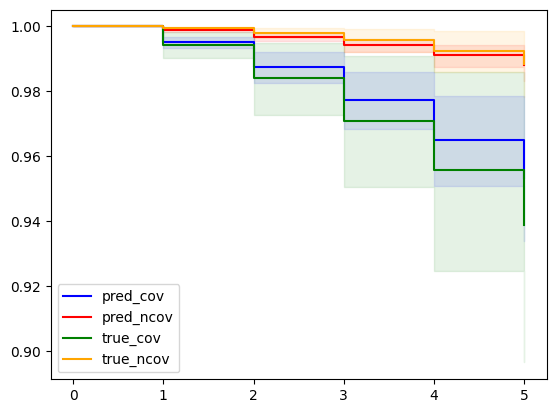

In [223]:
te_cov_msk = np.array(te_x_sk.iloc[:,0]==1)
plt.step(te_bart_sv_t, te_bart_sv_val[te_cov_msk,:].mean(0), label = "pred_cov", where="post", color="blue")
plt.fill_between(te_bart_sv_t, y1=p_c95[0,:], y2 = p_c95[1,:], step="post", alpha=0.1, color="blue")

plt.step(te_bart_sv_t, te_bart_sv_val[~te_cov_msk,:].mean(0), label = "pred_ncov", color="red", where="post")
plt.fill_between(te_bart_sv_t, y1=p_nc95[0,:], y2 = p_nc95[1,:], step="post", alpha=0.1, color="red")

plt.step(te_bart_sv_t, te_sv_f[te_cov_msk,:].mean(0), label = "true_cov", color="green", where="post")
plt.fill_between(te_bart_sv_t, y1=t_c95[0,:], y2 = t_c95[1,:], step="post", alpha=0.1, color="green")

plt.step(te_bart_sv_t, te_sv_f[~te_cov_msk,:].mean(0), label = "true_ncov", color="orange", where="post")
plt.fill_between(te_bart_sv_t, y1=t_nc95[0,:], y2 = t_nc95[1,:], step="post", alpha=0.1, color="orange")
plt.legend()

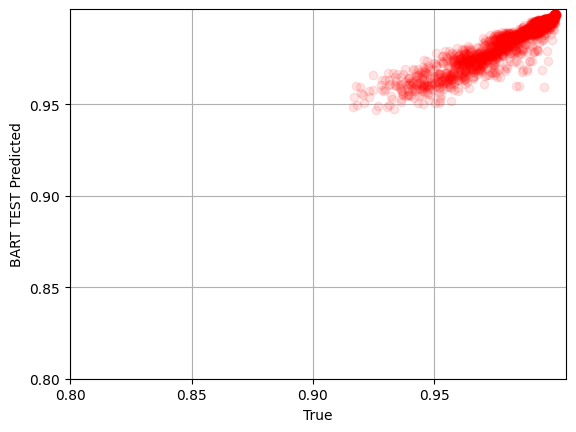

In [225]:
for i in np.arange(0,te_sv_f.shape[0]):
    plt.plot(te_sv_f[i,1:-1],te_bart_sv_val[i, 1:-1], "ro", alpha=0.1)
    # plt.plot(bart_sv_val[i,1:-1], cph_sv_val[i,1:-1],"bo", alpha=0.1)

plt.ylabel("BART TEST Predicted")
plt.xlabel("True")
plt.xticks(np.arange(0.80,1, 0.05))
plt.yticks(np.arange(0.80,1, 0.05))
plt.grid(visible=True)

In [226]:
# Cindex
shp1,shp2,shp3 = te_pp.posterior_predictive["mu"].values.shape
shp4 = te_x_sk.shape[0]
shp5 = np.unique(te_b_tr_t).shape[0]

bart_hz1 = te_pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
bart_chz1 = np.cumsum(bart_hz1, axis=1)
cph_chz = cph.predict_cumulative_hazard_function(te_x_sk)
cph_chz = np.array([fn(fn.x) for fn in cph_chz])

for i in np.arange(bart_hz1.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], bart_hz1[:,i])
    print(f"bart cindex {i}: {ci}")

for i in np.arange(cph_chz.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], cph_chz[:,i])
    print(f"cph cindex {i}: {ci}")


bart cindex 0: (0.672022358474305, 81874, 39958, 1, 21904)
bart cindex 1: (0.6724368602923674, 81925, 39908, 0, 21904)
bart cindex 2: (0.6737624453144878, 82086, 39746, 1, 21904)
bart cindex 3: (0.6733561514532187, 82037, 39796, 0, 21904)
bart cindex 4: (0.6749156632439487, 82227, 39606, 0, 21904)
cph cindex 0: (0.6910442983428136, 84192, 37641, 0, 21904)
cph cindex 1: (0.6910442983428136, 84192, 37641, 0, 21904)
cph cindex 2: (0.6910442983428136, 84192, 37641, 0, 21904)
cph cindex 3: (0.6910442983428136, 84192, 37641, 0, 21904)
cph cindex 4: (0.6910442983428136, 84192, 37641, 0, 21904)


In [227]:
# baseline c-index
te_chf = -np.log(te_sv_f)
# te_chf = -te_sv_f

for i in np.arange(1,te_chf.shape[1]):
    ci = concordance_index_censored(te_y_sk["Status"], te_y_sk["Survival_in_days"], te_chf[:,i])
    print(f"cph cindex {i}: {ci}")

cph cindex 1: (0.6873425098290282, 83741, 38092, 0, 21904)
cph cindex 2: (0.6874163814401681, 83750, 38083, 0, 21904)
cph cindex 3: (0.687465629180928, 83756, 38077, 0, 21904)
cph cindex 4: (0.6873178859586483, 83738, 38095, 0, 21904)
cph cindex 5: (0.6872604302610951, 83731, 38102, 0, 21904)


The c-index is comparable between the SAMPLE, CASE:COHORT and CPH

Interestingly, the c-index based on the true SV values converted to Cumalative Hazard evaluates to a similar value to the other trained values. 

This highlights the lack of discernability that the C-index provides. If the population does not seperate very distinctly the C-index is not strong.

In [255]:
# dy5_msk = np.where(te_y_sk["Survival_in_days"] == 5)
dy5_msk = np.where(coh_y["Survival_in_days"] == 5)
# y_skauc = te_y_sk.copy()
y_skauc = coh_y.copy()
y_skauc[0]["Survival_in_days"] = 6
y_skauc[0]["Status"] = True

dy5_msk2 = np.where(y_sk["Survival_in_days"] == 5)
y_skauc2 = te_y_sk.copy()
y_skauc2[0]["Survival_in_days"] = 6
y_skauc2[0]["Status"] = True

In [256]:
cph_cda = cumulative_dynamic_auc(
    survival_train=y_skauc2, 
    survival_test=te_y_sk, 
    estimate=cph_chz[:,:4], 
    times=bart_sv_t[1:5]
)

brt_cda = cumulative_dynamic_auc(
    survival_train=y_skauc, 
    survival_test=te_y_sk, 
    estimate=bart_hz1[:,:4], 
    times=bart_sv_t[1:5]
)

print(f"BART: {brt_cda}")
print(f"CPH: {cph_cda}")

BART: (array([0.68783069, 0.6855355 , 0.71152338, 0.71593621]), 0.7037309700267683)
CPH: (array([0.66941799, 0.69969317, 0.7040724 , 0.71908936]), 0.7039355703812286)


In [258]:
# cph_sv2 = np.hstack([np.repeat(1,cph_sv.shape[0]).reshape(cph_sv.shape[0],1), cph_sv[:, :]])
bart_ibs = integrated_brier_score(coh_y, te_y_sk, te_bart_sv_val[:, 1:5], te_bart_sv_t[1:5])
cph_ibs = integrated_brier_score(y_sk, te_y_sk, cph_sv_val[:, 1:5], te_bart_sv_t[1:5])

print(f"bart brier: {bart_ibs}")
print(f"cph brier: {cph_ibs}")

bart brier: 0.18695196655930793
cph brier: 0.19074863031949926


: 

In [145]:
def get_metrics(f_t, f, times, quants = np.array([0.1, 0.25, 0.5, 0.75, 0.9])):
    f_t = np.matrix(f_t)[:,times]
    f = np.matrix(f)[:, times]

    rmse = np.round(np.sqrt(np.mean(np.power(f_t - f, 2), axis=0)), 4)
    bias = np.round(np.mean(f_t - f, axis = 0), 4)
    
    return rmse, bias


In [146]:
bart_met =  get_metrics(te_sv_f, te_bart_sv_val, times = [1,2,3,4,5])
cph_met = get_metrics(te_sv_f, cph_sv_val, times = [1,2,3,4,5])


print(f"BART RMSE: {bart_met[0]}")
print(f"CPH RMSE: {cph_met[0]}")
print(f"BART BIAS: {bart_met[1]}")
print(f"CPH BIAS: {cph_met[1]}")


BART RMSE: [[0.0029 0.0041 0.0065 0.0096 0.0133]]
CPH RMSE: [[0.0022 0.0045 0.0074 0.0083 0.0113]]
BART BIAS: [[ 0.0021  0.0017  0.0011  0.0001 -0.0021]]
CPH BIAS: [[-0.0016 -0.0031 -0.0051 -0.0043 -0.0062]]
